In [0]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!rm -rf sample_data

     - 788kB 1.2MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=48ff782dec725d5c8e9abb278f37a5ae2ec64a189862f1bbda6828591f45cf40
  Stored in directory: /tmp/pip-ephem-wheel-cache-2an1yf3l/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [3]:
# data should be a zip file with data/images and data/images_pose
!unzip data

Archive:  data.zip
   creating: images/
  inflating: images/img3080.jpeg     
  inflating: images/img3921.jpeg     
  inflating: images/img4165.jpeg     
  inflating: images/img1054.jpeg     
  inflating: images/img4092.jpeg     
  inflating: images/img2038.jpeg     
  inflating: images/img4056.jpeg     
  inflating: images/img3346.jpeg     
  inflating: images/img2430.jpeg     
  inflating: images/img3410.jpeg     
  inflating: images/img1677.jpeg     
  inflating: images/img4290.jpeg     
  inflating: images/img2368.jpeg     
  inflating: images/img1177.jpeg     
  inflating: images/img4227.jpeg     
  inflating: images/img2710.jpeg     
  inflating: images/img741.jpeg      
  inflating: images/img743.jpeg      
  inflating: images/img3019.jpeg     
  inflating: images/img1810.jpeg     
  inflating: images/img2863.jpeg     
  inflating: images/img820.jpeg      
  inflating: images/img1469.jpeg     
  inflating: images/img4366.jpeg     
  inflating: images/img4173.jpeg     
  inflatin

In [0]:
import matplotlib, numpy as np, matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook as tqdm
import torchvision
from torchvision import datasets, models, transforms
from google.colab import drive
import os
from PIL import Image

In [0]:
def get_model(num_out):
    model = models.resnet18(pretrained=True)
    input_size = 224
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_out)
    trans = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return model, input_size, trans

In [0]:
class GazeboDataset(Dataset):

    # NB NB: All indexes in poses.txt is increased by 1 as compared to the corresponding image file
    def __init__(self, fn, img_transform):
        self.root = fn
        self.img_transform = img_transform
        self.target_transform = None
        self.size = len(os.listdir(os.path.join(self.root, "images/")))

        with open(os.path.join(self.root, "images_pose/poses.txt"), "r") as f:
            poses = f.readlines()
        
        self.coordinates = [i.strip().split()[1:3] for i in poses]
        self.coordinates = [[float(i) for i in j] for j in self.coordinates]
        self.coordinates = torch.Tensor(self.coordinates)
        
        #self.orientations = [i.stip().split()[-1] for i in poses]

        if len(self.coordinates) != self.size:
            print(self.size)
            print(len(self.coordinates))
            raise Exception("Number of coordinates is not equal number of images")

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    # Overloaded functions needed by torch.utils.data.DataLoader
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):

        path = "images/img" + str(idx) + ".jpeg"

        
        sample = self.pil_loader(os.path.join(self.root, path))
        target = self.coordinates[idx]

        if self.img_transform is not None:
            sample = self.img_transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

# ratios = [train_ratio, val_ratio, test_ratio]
# returns train, val, test loaders
def get_dataloaders(ratios, fn, data_transform, batch_size):
    full_dataset = GazeboDataset(fn, data_transform)
    sizes = [int(len(full_dataset)*i) for i in ratios]
    sizes[-1] = len(full_dataset) - sum(sizes[:-1])
    datasets = torch.utils.data.random_split(full_dataset, sizes)
    return [DataLoader(i, batch_size = batch_size, shuffle = True) for i in datasets]

In [0]:
def train(model, device, train_loader, optimizer, epoch, batch_size):
    model.train()
    sum_loss = 0

    batches = tqdm(enumerate(train_loader), total=len(train_loader))
    batches.set_description("Epoch NA: Loss (NA) Accuracy (NA %)")

    for batch_idx, (data, target) in batches:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output.view(target.shape), target.float())
        sum_loss += loss.item() * batch_size
        loss.backward()
        optimizer.step()

        batches.set_description(
            "Epoch {:d}: Loss ({:.2e})".format(
            epoch, loss.item()))
        
    avg_loss = sum_loss / len(train_loader.dataset)
    
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += torch.sum(F.mse_loss(output.view(target.shape), target.float(), reduction='sum')).item() # sum up batch loss
            
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.2e}'.format(test_loss))
    return test_loss

In [50]:
data_ratios = [0.7, 0.2, 0.1] # train, val, test
######################
# Hyperparams :
args = {}
args["seed"] = 1
args["batch_size"] = 32
args["lr"] = 0.001
args["cuda"] = True
args["epochs"] = 10
args["data_dir"] = os.getcwd()
args["out_features"] = 2
#######################

torch.manual_seed(args["seed"])

use_cuda = args["cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using", "cuda" if use_cuda else "cpu")

model, input_size, data_transform = get_model(args["out_features"])


train_loader, val_loader, test_loader = get_dataloaders(data_ratios,
                                                        args["data_dir"],
                                                        data_transform,
                                                        args["batch_size"])


model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=args["lr"])

training_losses = []
validation_losses = []

for epoch in range(1, args["epochs"] + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, args["batch_size"])
    print("Average train loss:", train_loss)

    val_loss = test(model, device, val_loader)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

test_loss = test(model, device, test_loader)


Using cuda


Average train loss: 68.36800297952013

Test set: Average loss: 8.52e+01


Average train loss: 20.659683256967778

Test set: Average loss: 1.86e+01


Average train loss: 12.781957105822366

Test set: Average loss: 1.86e+01


Average train loss: 11.16010389141008

Test set: Average loss: 1.64e+01


Average train loss: 8.446965418993106

Test set: Average loss: 1.77e+01


Average train loss: 9.52935934725853

Test set: Average loss: 6.72e+00


Average train loss: 7.1076071667770835

Test set: Average loss: 4.89e+01


Average train loss: 7.272010181541038

Test set: Average loss: 1.29e+02


Average train loss: 6.631201930154907

Test set: Average loss: 1.45e+01


Average train loss: 5.487413749093988

Test set: Average loss: 5.74e+00

Test set: Average loss: 5.02e+00


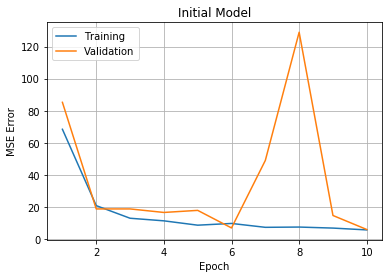

Val [85.2, 18.6, 18.6, 16.4, 17.7, 6.72, 48.9, 129, 14.5, 5.74]
Train [68.36800297952013, 20.659683256967778, 12.781957105822366, 11.16010389141008, 8.446965418993106, 9.52935934725853, 7.1076071667770835, 7.272010181541038, 6.631201930154907, 5.487413749093988]
Final test 5.022829445828213


In [57]:
validation_losses = [85.2, 18.6, 18.6, 16.4, 17.7, 6.72, 48.9, 129, 14.5, 5.74]
import matplotlib.pyplot as plt
epochs = np.arange(1,args["epochs"] + 1)
plt.plot(epochs, training_losses, label="Training")
plt.plot(epochs, validation_losses, label="Validation")
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Error")
plt.title("Initial Model")
plt.savefig("model1.png")
plt.savefig("model1.pdf")
plt.show()
print("Val", validation_losses)
print("Train", training_losses)
print("Final test", test_loss)